# Notebook 2: Neural Networks

In this notebook, we'll build a __multi-layer perceptron__ (__neural network__) in PyTorch and demonstrate how we can train using automatic differentiation. We'll evaluate our model on a number of synthetic datasets for a simple binary classification task.

The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [Multi-Layer Perceptron](#mlp)  
  3. [PyTorch Essentials](#torch)  
     3.1. [Defining a Model](#definition)  
     3.2. [Backpropagation in a Nutshell](#backprop)  
     3.3. [Optimizers](#opt)  
  4. [Training a Model](#train)  

## __1.__ <a name="setup">Setup</a>


Make sure the needed packages are installed and utility code is in the right place.

In [1]:
# helper code from the course repository
!cd /content && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd cs449w23/ && pip install -q -r requirements.txt

fatal: destination path 'cs449w23' already exists and is not an empty directory.


Let's import utility functions to create and plot simple two-dimensional datasets.

In [2]:
# this "magic" command makes graphics produced by matplotlib appear in the notebook.
%matplotlib inline

# make sure we're in the right directory
%cd /content/cs449w23/
!git pull origin main

import torch                  # This is PyTorch, what we're using for deep learning in class 
import numpy as np            # standard numerical processing library
from utils.plotting import *  # see plotting.py for plotting utilities
from utils.data import *      # see data.py for dataset utilities            

/content/cs449w23
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/zachwooddoughty/cs449w23
 * branch            main       -> FETCH_HEAD
   ed759a6..2eb8ffb  main       -> origin/main
Updating ed759a6..2eb8ffb
Fast-forward
 utils/data.py | 17 +++++++++++++++++
 1 file changed, 17 insertions(+)


---

## __2.__ <a name="mlp">Multi-Layer Perceptron</a>

As we saw in the previous notebook, a fundamental limitation of the perceptron is its inability to model nonlinear decision functions. To give our perceptron the capacity to model more complex functions, we can make a couple of tweaks:

1. We can combine multiple simple perceptron models in __layers__ to increase the number of learnable weights
2. We can introduce __nonlinearities__ (nonlinear activation functions) between layers to allow our model to express complicated nonlinear relationships

The resulting architecture is often called a __multi-layer perceptron__ or a __neural network__. As illustrated below, the combination of multiple weight layers and nonlinear activation functions is responsible for the multi-layer perceptron's increased expressivity.

<br/>
<center>
<img width="500px" src="https://raw.githubusercontent.com/zachwooddoughty/cs449w23/main/notebooks/static/mlp.png"/>
</center>
<br/>

The PyTorch library allows us to easily define neural network models using built-in components such as layers and activation functions. In the remainder of this notebook, we'll cover the basics of how to build and train neural networks in PyTorch.

---

## __3.__ <a name="torch">PyTorch Essentials</a>


### __3.1.__ <a name="definition">Defining A Model</a>

Below, we implement the neural network shown above using built-in PyTorch components. Our network class inerits from `torch.nn.Module`, and in addition to a constructor must define a `forward()` method to specify how the model processes inputs into outputs.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    """ Our first neural network model. We'll keep it simple."""
    
    # This bit determines the architecture of each layer...but not how data flows
    # Here we make 3 layers, which we named fc1, fc2 and fc3.
    def __init__(self, activation=torch.tanh):
        super().__init__() # has to be here

        self.layer1 = nn.Linear(2, 3)
        self.layer2 = nn.Linear(3, 2)
        self.layer3 = nn.Linear(2, 1)
        self.activation = activation
        
        for layer in [self.layer1, self.layer2, self.layer3]:
          nn.init.xavier_uniform_(layer.weight)

    # This part determines how data in x flows through the network. 
    # Here, x is the input to the network. 
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        return x

    
def print_model(model):
    """ 
    A simple functon that prints out a PyTorch model's structural details

    PARAMETERS
    ----------
    model     a torch.nn.Model
    """

    # Print model's state_dict
    print("Model's state dictionary (stored weights):")
    for param_tensor in model.state_dict():
        print("  ", param_tensor, "\t", tuple(model.state_dict()[param_tensor].size()))

    # Print the number of parameters in the model    
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " trainable parameters")


# initialize a model and examine its weights
net = Net()
print_model(net)

# given a 2-dimensional input...
x = torch.randn(2)

# ...the model produces 1-dimensional output
output = net(x)
print(f"Input dimension: {x.shape}, Output dimension: {output.shape}")

Model's state dictionary (stored weights):
   layer1.weight 	 (3, 2)
   layer1.bias 	 (3,)
   layer2.weight 	 (2, 3)
   layer2.bias 	 (2,)
   layer3.weight 	 (1, 2)
   layer3.bias 	 (1,)
In total, this network has  20  trainable parameters
Input dimension: torch.Size([2]), Output dimension: torch.Size([1])


### __3.2.__ <a name="backprop">Backpropagation in a Nutshell</a>

Whereas our simple perceptron mapped two-dimensional inputs directly to scalar outputs, a neural network can map inputs through a number of __intermediate ("hidden") representations__ of varying dimensions. This additional complexity helps our model learn more difficult functions, but it also means we can no longer use the simple perceptron learning algorithm to train (i.e. we can no longer update our weights by directly adding incorrectly-predicted inputs). 

Luckily for us, the perceptron learning algorithm is just one of many optimization techniques that propagates an error measurement from the model's output to its weights in order to perform updates. When this error measurement is provided by a differentiable __loss function__ and our model's output is differentiable with respect to its weights, we can propagate error by computing the __gradient__ of the loss function with respect to each weight and performing a small update in the opposite direction of the gradient. The computation of these gradients is called __backpropagation__, and allows us to systematically train large and complex neural networks. 


If all of this sounds like a lot of work, don't worry -- PyTorch provides __automatic differentiation__, meaning that gradient computation is handled for us under-the-hood. Once a network is defined, training can be accomplished using a few function calls in a standard loop!

In [4]:
# in PyTorch, all data (e.g. inputs, outputs, weights) is stored in Tensor objects. 
# Tensors act similarly to NumPy arrays, and share many methods
x = torch.zeros(10)
print(f"Creating a tensor of type {type(x)} with shape {x.shape}")
print(f"Starting x: {x}")

# During backpropagation, gradients will only be computed for tensors with the 
# `requires_grad` attribute set to True. We can set this manually if need be
print(f"Does our tensor require gradient computation? {x.requires_grad}")
x.requires_grad = True
print(f"Does our tensor require gradient computation? {x.requires_grad}")

# To perform backpropagation, we need to complete a "forward pass" in which 
# computations are performed on Tensor objects to compute a scalar loss value
loss = 10 - x.sum()
print(f"Starting `loss` value: {loss}")
print(f"Gradients of x: {x.grad}")

# PyTorch will compute all required gradients for tensors involved in the 
# computation of a scalar loss value once we call `.backward()`
loss.backward()
print(f"Gradients of x: {x.grad}")

# We can update our `weights` in the opposite direction of this gradient to reduce our
# loss value!
x = x - x.grad
print(f"Updated x: {x.data}")
loss = 10 - x.sum()
print(f"Updated `loss` value: {loss}")

Creating a tensor of type <class 'torch.Tensor'> with shape torch.Size([10])
Starting x: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Does our tensor require gradient computation? False
Does our tensor require gradient computation? True
Starting `loss` value: 10.0
Gradients of x: None
Gradients of x: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
Updated x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Updated `loss` value: 0.0


### __3.3__ <a name="opt">Optimizers</a>

In the above example we computed differentiable a scalar loss, used backpropagation to compute the gradients of the loss with respect to our "weights," and performed a gradient-based update on our weights to reduce the loss. Rather than managing the weight-update process by hand, we can defer to a built-in __optimizer__ object that automatically adjusts weights based on stored gradients and standard hyperparameters (e.g. learning rate). When training neural networks with large numbers of parameters, this becomes much simpler than manually updating each weight.

In [5]:
# repeat our simple optimization, this time using the optimizer
x = torch.zeros(10).requires_grad_(True)
print(f"Starting x: {x}")

# create an optimizer object and pass it an Iterable containing our "weights"
opt = torch.optim.SGD([x], lr = 1.0)

# compute loss and perform backpropagation
loss = 10 - x.sum()
loss.backward()

# perform an optimization step, i.e. a gradient-based update of our weights
opt.step()

print(f"Updated x: {x}")

Starting x: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Updated x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)


## __4.__ <a name="train">Training a Model</a>

In the above examples, we "trained" a single tensor to minimize a loss function. Next, we'll use the same basic approach to train a neural network for a binary classification task.

In [6]:
def train_model(model, data, target):
    """ 
    A simple functon that runs the network model through one epoch of the 
    training data and then updates the weights to move moodel output closer to the
    target output. 

    PARAMETERS
    ----------
    model   A torch.nn.Model
    data    A 2-D torch tensor where data[i] contains the ith example.
    target  A torch tensor where target[i]  contains the expected output of the
            model in response to input data[i]
    """
    
    # This tells your model that you are in training mode, so that layers (like
    # dropout, batchnorm) with different train-time and test-time behavior can
    # behave accordingly. It doesn't do much on our simple model, but you need 
    # to do this as a standard practice!
    model.train()

    # Set the gradients to 0 before running the network on the data, so that 
    # loss gradients can be computed correctly during backpropagation
    optimizer.zero_grad()

    # Get the output of the network on the data 
    output = model(data)

    # Measure the "loss" using mean squared error
    loss = F.mse_loss(output.squeeze(), target)

    # This calculates the gradients, performing backpropagation to propagate
    # errors backward through the network's weights
    loss.backward()

    # This updates the network weights based on the freshly-computed gradient 
    # now stored alongside each weight
    optimizer.step()


def test_model(model, data, target):
    """
    A simple functon that prints out the model's loss and accuracy on the 
    data  

    PARAMETERS
    ----------
    model     a torch.nn.Model
    data      a 2-D torch tensor where data[i] contains the ith example.
    target    a torch tensor where target[i]  contains the expected output
            of the model in response to input data[i]
    RETURNS
    -------
    accuracy  The accuracy on the data

    loss      The loss on the data
    """
    
    # This puts the network in evaluation mode so that layers (like
    # dropout, batchnorm) with different train-time and test-time behavior can
    # behave accordingly. It doesn't do much on our simple model, but you need 
    # to do this as a standard practice!
    model.eval()

    # torch.no_grad() tells the system to stop keeping track of gradients (derivatives)
    # when performing calculations. This makes things run faster. 
    with torch.no_grad():
        
        # Get the output of the network on a batch of test examples
        output = model(data)
        output = output.squeeze()
        
        # Measure loss 
        loss = F.mse_loss(output, target)

        # Get the (thresholded) predictions of the network
        prediction = torch.sign(output)

        # Measure the accuracy of the predictions 
        c = prediction*target
        accuracy = torch.mean((c+1)/2)

        # lets report 
        #print('\nTest set: loss = ', round(loss.item(),4),
        #      ' accuracy = ', round(accuracy.item(),3), '\n')
        accuracy = round(accuracy.item(),3)
        loss = round(loss.item(),4)
        
    return accuracy, loss

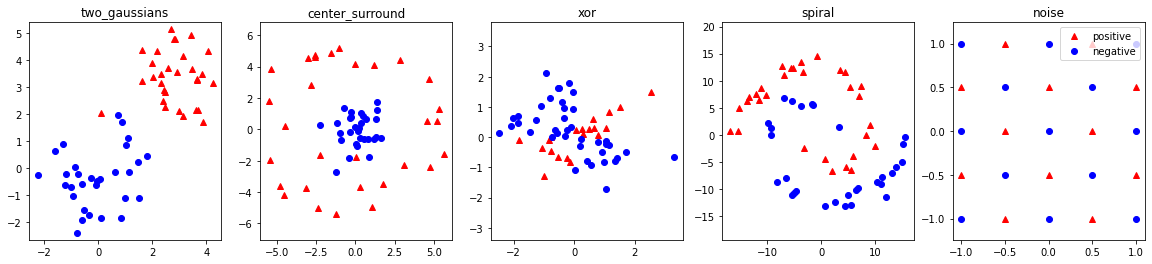

In [7]:
# Datasets
np.random.seed(3)
datasets = {
  "two_gaussians": make_two_gaussians_data(examples_per_class=30, distance_between_means=3),
  "center_surround": make_center_surround_data(examples_per_class=30, distance_from_origin=5),
  "xor": make_XOR_data(examples_per_class=30),
  "spiral": make_spiral_data(examples_per_class=30),
  "noise": make_noise_dataset(examples_per_class=10),
}

fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(4 * len(datasets), 4))
for idx, name in enumerate(datasets):
   data, labels = datasets[name]
   plot_data(data, labels, axes[idx])
   axes[idx].set_title(name)

plt.show()

With our basic training and evaluation procedures defined, we can finally train a neural network! We'll start by loading converting our data into torch tensors.

In [8]:
# the data is in 64bit NumPy format, so we need to reformat the data as Tensors for PyTorch
def dataset_to_tensors(name):
  x_numpy, y_numpy = datasets[name]
  x_torch = torch.tensor(x_numpy).to(dtype=torch.float32)
  y_torch = torch.tensor(y_numpy).to(dtype=torch.float32)
  return x_numpy, y_numpy, x_torch, y_torch

x_numpy, y_numpy, x_torch, y_torch = dataset_to_tensors("two_gaussians")

We can visualize the decision boundary drawn by our untrained model, as well as its initial accuracy.

Model's state dictionary (stored weights):
   layer1.weight 	 (3, 2)
   layer1.bias 	 (3,)
   layer2.weight 	 (2, 3)
   layer2.bias 	 (2,)
   layer3.weight 	 (1, 2)
   layer3.bias 	 (1,)
In total, this network has  20  trainable parameters
accuracy=0.35 loss=1.8441


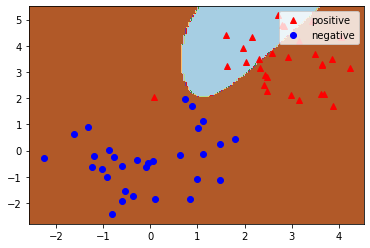

In [9]:
net = Net()
print_model(net)

scale = 1

# look at the decision surface and model decision surface
plot_data(x_numpy, y_numpy)
xmin, xmax, ymin, ymax=plt.axis()
plot_decision_surface(model=net, axis_limits=[xmin*scale, xmax*scale, ymin*scale, ymax*scale])

# measure model accuracy
accuracy, loss = test_model(net, x_torch, y_torch)
print('accuracy=' + str(accuracy)+ ' loss=' + str(loss))

Finally, let's train our model.

accuracy=1.0 loss=0.0022


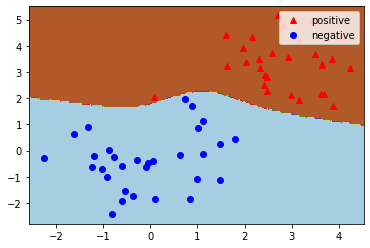

In [10]:
epochs = 1000
scale = 1
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for i in range(0,epochs):
    train_model(net, x_torch, y_torch)

plot_data(x_numpy, y_numpy)
xmin, xmax, ymin, ymax = plt.axis()
plot_decision_surface(model=net, axis_limits=[xmin*scale, xmax*scale, ymin*scale, ymax*scale])
accuracy, loss = test_model(net, x_torch, y_torch)
print('accuracy=' + str(accuracy)+ ' loss=' + str(loss))

As we can see, our simple neural network is capable of modeling nonlinear decision functions! Using the steps above, we can easily "scale up" our network to allow even more expressivity.

Model's state dictionary (stored weights):
   fc1.weight 	 (100, 2)
   fc1.bias 	 (100,)
   fc2.weight 	 (10, 100)
   fc2.bias 	 (10,)
   fc3.weight 	 (1, 10)
   fc3.bias 	 (1,)
In total, this network has  1321  trainable parameters
accuracy=1.0 loss=0.0011


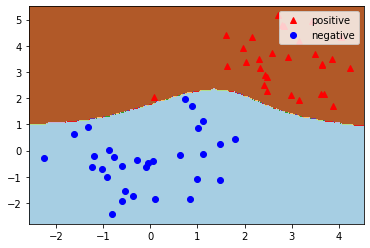

In [11]:
class BigNet(nn.Module):
    """ Our second neural network model. We'll still keep it simple."""
    
    # this bit determines the architecture of each layer...but not how data flows
    def __init__(self):
        super().__init__() # has to be here
        self.fc1 = nn.Linear(2,100)
        self.fc2 = nn.Linear(100,10)
        self.fc3 = nn.Linear(10,1)

    # this part determines how data in x flows through the network. 
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

# initialize our model
bignet = BigNet()
optimizer = torch.optim.SGD(bignet.parameters(), lr=0.01, momentum=0.9)
print_model(bignet)

epochs = 1000
scale = 1

for i in range(0,epochs):
    train_model(bignet, x_torch, y_torch)

plot_data(x_numpy, y_numpy)
xmin,xmax,ymin,ymax = plt.axis()
plot_decision_surface(model=bignet, axis_limits=[xmin*scale,xmax*scale,ymin*scale,ymax*scale])
accuracy, loss = test_model(bignet, x_torch, y_torch)
print('accuracy=' + str(accuracy)+ ' loss=' + str(loss))

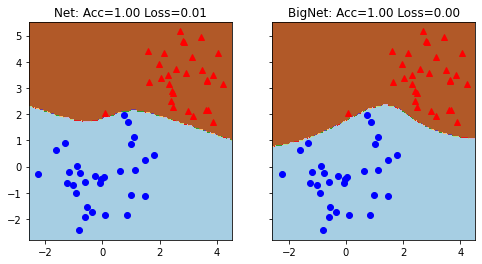

In [18]:
name = "two_gaussians"
# name = "center_surround"
# name = "xor"
# name = "spiral"
# name = "noise"
x_numpy, y_numpy, x_torch, y_torch = dataset_to_tensors(name)

# set the boundaries of decision plot

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
for ax in axes:
  plot_data(x_numpy, y_numpy, ax=ax)
  xmin, xmax, ymin, ymax = ax.axis()

limits = [xmin * scale, xmax * scale, ymin * scale, ymax * scale]

epochs = 1000
scale = 1

net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
for i in range(0, epochs):
    train_model(net, x_torch, y_torch)

plot_decision_surface(model=net, axis_limits=limits, ax=axes[0])
accuracy, loss = test_model(net, x_torch, y_torch)
axes[0].set_title(f"Net: Acc={accuracy:.2f} Loss={loss:.2f}")

bignet = BigNet()
optimizer = torch.optim.SGD(bignet.parameters(), lr=0.01, momentum=0.9)
for i in range(0, epochs):
    train_model(bignet, x_torch, y_torch)

plot_decision_surface(model=bignet, axis_limits=limits, ax=axes[1])
accuracy, loss = test_model(bignet, x_torch, y_torch)
axes[1].set_title(f"BigNet: Acc={accuracy:.2f} Loss={loss:.2f}")
axes[1].get_legend().remove()

plt.show()

In [13]:
# Let's introduce a bit of experimental design

from sklearn.model_selection import train_test_split

def dataset_to_tensors_with_split(name):
  x_numpy, y_numpy = datasets[name]

  x_numpy_train, x_numpy_test, y_numpy_train, y_numpy_test = train_test_split(
      x_numpy, y_numpy, test_size=0.2, random_state=1
  )

  x_torch_train = torch.tensor(x_numpy_train).to(dtype=torch.float32)
  x_torch_test = torch.tensor(x_numpy_test).to(dtype=torch.float32)
  y_torch_train = torch.tensor(y_numpy_train).to(dtype=torch.float32)
  y_torch_test = torch.tensor(y_numpy_test).to(dtype=torch.float32)
  return [
      (x_numpy_train, x_numpy_test, y_numpy_train, y_numpy_test),
      (x_torch_train, x_torch_test, y_torch_train, y_torch_test)
  ]

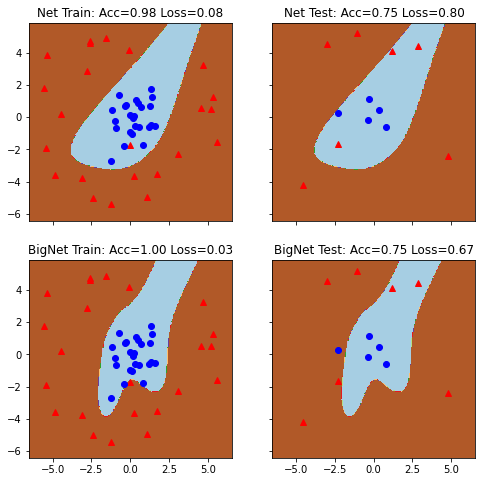

In [19]:
# name = "two_gaussians"
name = "center_surround"
# name = "xor"
# name = "spiral"
# name = "noise"

numpy_data, torch_data = dataset_to_tensors_with_split(name)
(x_numpy_train, x_numpy_test, y_numpy_train, y_numpy_test) = numpy_data
(x_torch_train, x_torch_test, y_torch_train, y_torch_test) = torch_data

scale = 1
limits = [np.min(x_numpy_train[:, 0]) * scale - 1,
          np.max(x_numpy_train[:, 0]) * scale + 1,
          np.min(x_numpy_train[:, 1]) * scale - 1,
          np.max(x_numpy_train[:, 1]) * scale + 1,]

# Train both models on the training data
epochs = 1000

net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
for i in range(0, epochs):
    train_model(net, x_torch_train, y_torch_train)

bignet = BigNet()
optimizer = torch.optim.SGD(bignet.parameters(), lr=0.01, momentum=0.9)
for i in range(0, epochs):
    train_model(bignet, x_torch_train, y_torch_train)

# Create a grid of four plots
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(8, 8))

# Top left: Net train
axis = axes[0, 0]
plot_data(x_numpy_train, y_numpy_train, ax=axis)
plot_decision_surface(model=net, axis_limits=limits, ax=axis)
accuracy, loss = test_model(net, x_torch_train, y_torch_train)
axis.set_title(f"Net Train: Acc={accuracy:.2f} Loss={loss:.2f}")

# Top right: Net test
axis = axes[0, 1]
plot_data(x_numpy_test, y_numpy_test, ax=axis)
xmin, xmax, ymin, ymax = ax.axis()
plot_decision_surface(model=net, axis_limits=limits, ax=axis)
accuracy, loss = test_model(net, x_torch_test, y_torch_test)
axis.set_title(f"Net Test: Acc={accuracy:.2f} Loss={loss:.2f}")

# Bottom Left: BigNet train
axis = axes[1, 0]
plot_data(x_numpy_train, y_numpy_train, ax=axis)
xmin, xmax, ymin, ymax = ax.axis()
plot_decision_surface(model=bignet, axis_limits=limits, ax=axis)
accuracy, loss = test_model(bignet, x_torch_train, y_torch_train)
axis.set_title(f"BigNet Train: Acc={accuracy:.2f} Loss={loss:.2f}")

# Bottom right: BigNet test
axis = axes[1, 1]
plot_data(x_numpy_test, y_numpy_test, ax=axis)
xmin, xmax, ymin, ymax = ax.axis()
plot_decision_surface(model=bignet, axis_limits=limits, ax=axis)
accuracy, loss = test_model(bignet, x_torch_test, y_torch_test)
axis.set_title(f"BigNet Test: Acc={accuracy:.2f} Loss={loss:.2f}")

axes[1, 1].get_legend().remove()

plt.show()